# Case Study 6

## Description


Build a dense neural network to accurately detect the particle. The goal is to maximize your accuracy.
Include a discussion of how you know your model has finished training as well as what design decisions
you made while building the network.

Submit your assignment to the Assignments section of the online campus. For more information regarding
case studies, see the syllabus.

In [1]:
# Import general libraries
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

# Import sklearn libraries
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Set up OS-level processes
import os
cwd = os.getcwd()
d = os.path.dirname(cwd)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set pandas display options
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 99999

In [2]:
# %%time

# # Read in data and save it as a pickle file
# data = pd.read_csv('all_train.csv')
# data.to_pickle("data.pkl")

In [3]:
# Load pickle file
df = pd.read_pickle("data.pkl")

## Exploratory Data Analysis

In [4]:
df.shape

(7000000, 29)

In [5]:
df.head()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,0.754261,2.269852,-1.300984,-1.199420,-1.161915,3.357043,0.460796,-0.404118,-0.815440,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1.0,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,0.754261,0.459217,-0.695640,0.359856,-1.161915,-0.502048,0.505149,-1.500441,1.226331,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0.0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,0.754261,-1.031239,1.912465,-1.321417,-1.161915,-0.406757,1.346497,-0.298099,1.226331,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0
3,1.0,-0.377914,-0.103932,-0.649434,-2.125015,-1.643797,-0.005984,1.011112,-1.040340,-0.541991,0.754261,1.142262,0.551081,1.016731,0.860649,0.454005,0.624624,1.439072,-0.815440,0.463763,-0.006583,1.089122,-0.573682,-0.276348,-0.409272,-0.349926,-0.307123,0.529698,1250.0
4,0.0,-0.067436,-0.636762,-0.620166,-0.062551,1.588715,-0.005984,-0.595304,-1.238987,0.336844,-1.325801,-0.181512,-1.329374,0.879087,0.860649,-0.143564,-1.293935,-1.222800,-0.815440,-0.552837,-1.418494,-0.562982,1.743123,0.881802,0.002516,1.560950,-0.150760,-1.023889,750.0


In [6]:
df.tail()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
6999995,0.0,1.617264,-0.537084,-1.275867,0.650799,-1.511621,0.850488,0.596391,-0.054678,0.728849,0.754261,0.642273,-0.830321,-0.135583,-1.161915,-0.080789,-0.387230,0.395537,-0.815440,0.664328,-0.960709,-0.894011,1.743123,-0.426198,-0.324286,-0.432739,1.340297,0.267774,750.000000
6999996,0.0,-0.511357,0.270927,0.085989,-0.243802,-1.035668,-0.005984,-0.127219,0.721426,1.404479,-1.325801,-0.116903,1.924123,-0.324101,0.860649,0.435727,-0.307681,0.520873,1.226331,-1.015462,1.367217,-1.053815,-0.573682,-1.907798,0.194661,-0.190621,0.027776,-0.316018,1250.000000
6999997,1.0,0.062408,-0.987203,0.570667,1.517195,0.639548,-1.054221,1.115239,1.261928,-1.009308,0.754261,0.606688,-0.671159,0.910398,0.860649,1.012521,1.395015,-1.292659,-0.815440,0.790842,0.892545,-0.192816,-0.573682,0.973622,1.034964,-0.340661,-0.181193,1.877042,1500.000000
6999998,1.0,1.659131,1.096223,0.562821,1.627193,0.767236,-1.054221,1.079999,0.155488,-1.412207,-1.325801,1.426934,0.010469,-0.912317,0.860649,1.287494,0.457677,0.222345,1.226331,-0.671423,-0.308908,-0.568336,-0.573682,1.043119,1.270350,0.217405,0.120213,1.073020,1500.000000
6999999,1.0,0.002034,0.744152,-0.908839,-0.770454,1.008405,-1.054221,-0.370155,0.296837,-1.492524,0.754261,-0.060033,0.480335,0.600689,0.860649,-0.310234,1.444980,-0.900647,-0.815440,0.352893,0.671047,0.176512,-0.573682,0.314739,0.304983,0.425471,-0.612085,-0.925097,499.999969


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000000 entries, 0 to 6999999
Data columns (total 29 columns):
 #   Column   Dtype  
---  ------   -----  
 0   # label  float64
 1   f0       float64
 2   f1       float64
 3   f2       float64
 4   f3       float64
 5   f4       float64
 6   f5       float64
 7   f6       float64
 8   f7       float64
 9   f8       float64
 10  f9       float64
 11  f10      float64
 12  f11      float64
 13  f12      float64
 14  f13      float64
 15  f14      float64
 16  f15      float64
 17  f16      float64
 18  f17      float64
 19  f18      float64
 20  f19      float64
 21  f20      float64
 22  f21      float64
 23  f22      float64
 24  f23      float64
 25  f24      float64
 26  f25      float64
 27  f26      float64
 28  mass     float64
dtypes: float64(29)
memory usage: 1.5 GB


In [8]:
df.describe()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,5.001256e-01,1.612528e-02,4.770022e-04,2.686578e-05,1.056081e-02,-1.050026e-04,2.765919e-03,1.815953e-02,2.510948e-05,4.345870e-04,-6.869956e-03,1.754267e-02,-1.610605e-04,-3.289412e-04,1.738506e-03,1.724634e-02,4.830252e-04,-5.536178e-04,4.960189e-03,1.164789e-02,-1.127097e-04,7.686731e-05,2.909202e-04,1.228774e-02,9.778378e-03,5.269844e-03,-1.760961e-03,1.533136e-02,1.000107e+03
std,5.000000e-01,1.004417e+00,9.974864e-01,1.000080e+00,9.956003e-01,9.998670e-01,1.000957e+00,9.867746e-01,9.965867e-01,1.000007e+00,1.001938e+00,9.941511e-01,9.984497e-01,1.000078e+00,9.997368e-01,9.994654e-01,9.984289e-01,9.998608e-01,1.001006e+00,1.002725e+00,1.000038e+00,1.000033e+00,1.000170e+00,1.010477e+00,1.005418e+00,1.009990e+00,9.844511e-01,9.822799e-01,3.534255e+02
min,0.000000e+00,-1.960549e+00,-2.365355e+00,-1.732165e+00,-9.980274e+00,-1.732137e+00,-1.054221e+00,-3.034787e+00,-2.757853e+00,-1.732359e+00,-1.325801e+00,-2.835563e+00,-2.602091e+00,-1.732216e+00,-1.161915e+00,-2.454879e+00,-2.437812e+00,-1.732145e+00,-8.154401e-01,-1.728284e+00,-2.281867e+00,-1.731758e+00,-5.736825e-01,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.632761e+00,5.000000e+02
25%,0.000000e+00,-7.288206e-01,-7.332548e-01,-8.656704e-01,-6.092291e-01,-8.658025e-01,-1.054221e+00,-7.566092e-01,-7.014146e-01,-8.656543e-01,-1.325801e+00,-7.237266e-01,-7.032926e-01,-8.665987e-01,-1.161915e+00,-6.996179e-01,-7.070255e-01,-8.662470e-01,-8.154401e-01,-7.423630e-01,-7.206846e-01,-8.656855e-01,-5.736825e-01,-5.417942e-01,-5.115522e-01,-3.543870e-01,-6.925097e-01,-7.943804e-01,7.500000e+02
50%,1.000000e+00,-3.930319e-02,8.523957e-04,3.199154e-04,1.963316e-02,-5.070131e-04,-5.983562e-03,-1.499527e-01,-1.067553e-04,1.384781e-03,7.542607e-01,-1.285732e-01,-5.755420e-04,-1.282098e-03,8.606486e-01,-9.749269e-02,2.975658e-04,-1.376716e-03,-8.154401e-01,-8.992496e-02,-6.735953e-05,-4.424527e-04,-5.736825e-01,-1.602760e-01,-3.144032e-01,-3.265228e-01,-3.570301e-01,-8.828640e-02,1.000000e+03
75%,1.000000e+00,6.900799e-01,7.347832e-01,8.659464e-01,6.798818e-01,8.657646e-01,8.504885e-01,7.686690e-01,7.013194e-01,8.665976e-01,7.542607e-01,6.478635e-01,7.041004e-01,8.658323e-01,8.606486e-01,6.347052e-01,7.083709e-01,8.649424e-01,1.226331e+00,6.423185e-01,7.204921e-01,8.659566e-01,-5.736825e-01,4.812194e-01,1.634892e-01,-2.337671e-01,4.753128e-01,7.610846e-01,1.250000e+03
max,1.000000e+00,4.378282e+00,2.365287e+00,1.732370e+00,4.148023e+00,1.731978e+00,4.482618e+00,3.720345e+00,2.758590e+00,1.731450e+00,7.542607e-01,4.639335e+00,2.602294e+00,1.732007e+00,8.606486e-01,5.535799e+00,2.438369e+00,1.732738e+00,1.226331e+00,5.866367e+00,2.282217e+00,1.732740e+00,1.743123e+00,7.293420e+00,9.333287e+00,1.499064e+01,5.277313e+00,4.444690e+00,1.500000e+03


In [9]:
# Missing values?
df.isnull().sum()

# label    0
f0         0
f1         0
f2         0
f3         0
f4         0
f5         0
f6         0
f7         0
f8         0
f9         0
f10        0
f11        0
f12        0
f13        0
f14        0
f15        0
f16        0
f17        0
f18        0
f19        0
f20        0
f21        0
f22        0
f23        0
f24        0
f25        0
f26        0
mass       0
dtype: int64

In [10]:
# Number of unique values per feature
df.nunique()

# label          2
f0         1142885
f1         2311224
f2         1849439
f3         1359060
f4         1849442
f5              10
f6         1129730
f7         2383592
f8         1850813
f9               2
f10        1063674
f11        2358787
f12        1850048
f13              2
f14         979658
f15        2320116
f16        1851285
f17              2
f18         882518
f19        2263637
f20        1850152
f21              2
f22        1142839
f23         568614
f24         393987
f25         862612
f26         931270
mass             5
dtype: int64

In [11]:
df['# label'].value_counts()

1.0    3500879
0.0    3499121
Name: # label, dtype: int64

In [12]:
# Convert label to an integer
df['# label'] = df['# label'].astype(int)

# Verify conversion
df['# label'].value_counts()

1    3500879
0    3499121
Name: # label, dtype: int64

## Helper Functions

In [22]:
def get_confusion_matrix(y, yhat,mat_title="Confusion Matrix"):
    x_axis_labels = ['non-detection','detection']
    y_axis_labels = ['non-detection','detection']
    cm_n = confusion_matrix(y, yhat)
    ax = sns.heatmap(cm_n,cmap='Blues',annot=True,fmt='2d',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    ax.set_title(mat_title,fontdict={'fontsize':20},pad=15)

def get_classification_report(x_train, y_train, x_test, y_test, pred, model):
    """
    This function is used to get comprehensive classification report for binary response:
    Training Accuracy, Test Accuracy, print classification_report, plot confusion matrix.
    """
    print("Classification Report:")
    print(classification_report(y_test,pred))
    get_confusion_matrix(y_test,pred)

## Set up Train/Test Data

In [13]:
# Define X & y
X, y = df.drop('# label', axis = 1), df['# label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.10, 
                                                    shuffle = True,
                                                    random_state = 123, 
                                                    stratify = y)

# Define and scale the testing and training data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Build Initial Neural Network

In [14]:
# Build a sequential NN model using Tensorflow and Keras
# model = Sequential()
# model.add(InputLayer(input_shape = (28,)))
# model.add(Dense(units = 100, activation = 'relu'))
# model.add(Dense(units = 100, activation = 'relu'))
# model.add(Dense(units = 1,   activation = 'sigmoid'))
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [27]:
# Build a sequential NN model using Tensorflow and Keras
model = Sequential()
model.add(Dense(hidden_units, input_dim = 28))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
add(Activation('softmax'))

NameError: name 'hidden_units' is not defined

In [15]:
%%time

model.fit(x = X_train, 
          y = y_train, 
          batch_size = 100000,
          epochs = 1000,
          validation_data = (X_test, y_test), verbose = 1,
          callbacks = [EarlyStopping(monitor = 'val_loss', 
                                     mode = 'min', 
                                     verbose = 1, 
                                     patience = 15)]
          )

Epoch 1/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.5085 - val_loss: 0.3856
Epoch 2/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.3694 - val_loss: 0.3559
Epoch 3/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.3468 - val_loss: 0.3372
Epoch 4/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.3325 - val_loss: 0.3276
Epoch 5/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.3245 - val_loss: 0.3213
Epoch 6/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.3189 - val_loss: 0.3166
Epoch 7/1000
63/63 [==============================] - 5s 74ms/step - loss: 0.3147 - val_loss: 0.3129
Epoch 8/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.3114 - val_loss: 0.3100
Epoch 9/1000
63/63 [==============================] - 5s 76ms/step - loss: 0.3086 - val_loss: 0.3076
Epoch 10/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.3064 - val_lo

63/63 [==============================] - 5s 72ms/step - loss: 0.2772 - val_loss: 0.2775
Epoch 82/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.2771 - val_loss: 0.2774
Epoch 83/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.2769 - val_loss: 0.2770
Epoch 84/1000
63/63 [==============================] - 4s 70ms/step - loss: 0.2768 - val_loss: 0.2770
Epoch 85/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2767 - val_loss: 0.2767
Epoch 86/1000
63/63 [==============================] - 4s 70ms/step - loss: 0.2764 - val_loss: 0.2767
Epoch 87/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2765 - val_loss: 0.2765
Epoch 88/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2762 - val_loss: 0.2764
Epoch 89/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2762 - val_loss: 0.2778
Epoch 90/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2761 - val_loss: 0

Epoch 161/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2716 - val_loss: 0.2722
Epoch 162/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2716 - val_loss: 0.2719
Epoch 163/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2718 - val_loss: 0.2722
Epoch 164/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2716 - val_loss: 0.2724
Epoch 165/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2715 - val_loss: 0.2719
Epoch 166/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2716 - val_loss: 0.2719
Epoch 167/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2715 - val_loss: 0.2718
Epoch 168/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2713 - val_loss: 0.2721
Epoch 169/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2714 - val_loss: 0.2717
Epoch 170/1000
63/63 [==============================] - 4s 71ms/step - lo

63/63 [==============================] - 4s 71ms/step - loss: 0.2692 - val_loss: 0.2696
Epoch 241/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2693 - val_loss: 0.2696
Epoch 242/1000
63/63 [==============================] - 5s 75ms/step - loss: 0.2693 - val_loss: 0.2700
Epoch 243/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.2692 - val_loss: 0.2701
Epoch 244/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.2692 - val_loss: 0.2695
Epoch 245/1000
63/63 [==============================] - 5s 73ms/step - loss: 0.2691 - val_loss: 0.2696
Epoch 246/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2693 - val_loss: 0.2696
Epoch 247/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2692 - val_loss: 0.2699
Epoch 248/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2690 - val_loss: 0.2696
Epoch 249/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2691 - va

63/63 [==============================] - 4s 72ms/step - loss: 0.2678 - val_loss: 0.2684
Epoch 320/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2680 - val_loss: 0.2689
Epoch 321/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2679 - val_loss: 0.2683
Epoch 322/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2677 - val_loss: 0.2683
Epoch 323/1000
63/63 [==============================] - 5s 72ms/step - loss: 0.2677 - val_loss: 0.2686
Epoch 324/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2679 - val_loss: 0.2690
Epoch 325/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2682 - val_loss: 0.2683
Epoch 326/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2678 - val_loss: 0.2683
Epoch 327/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2678 - val_loss: 0.2682
Epoch 328/1000
63/63 [==============================] - 4s 71ms/step - loss: 0.2678 - va

In [16]:
model_loss = pd.DataFrame(model.history.history)

In [17]:
def plot_early_stop_rounds(model_loss):
    plt.subplots(figsize = (10, 6))
    plt.plot(model_loss['loss'],lw = 2.5, label = 'train')
    plt.plot(model_loss['val_loss'],lw = 2.5, label = 'test')
    plt.title('Train/Test Loss vs. Epochs',fontdict = {'fontsize':20}, pad = 15)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

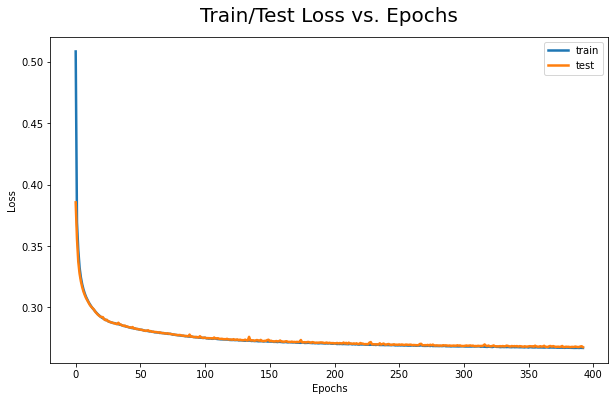

In [18]:
plot_early_stop_rounds(model_loss)

In [19]:
# Save the train/test loss history
file_name_model_history = "train_test_history.sav"
joblib.dump(model_loss, file_name_model_history)

['train_test_history.sav']

In [20]:
# Load the loss history
model_loss = joblib.load(file_name_model_history)

21875/21875 [==============================] - 12s 529us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88    349912
           1       0.87      0.90      0.88    350088

    accuracy                           0.88    700000
   macro avg       0.88      0.88      0.88    700000
weighted avg       0.88      0.88      0.88    700000



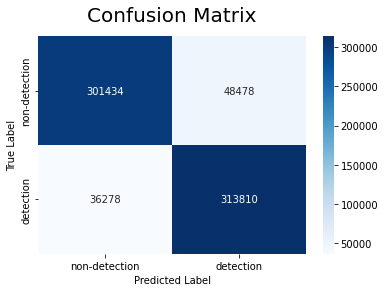

In [23]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
get_classification_report(X_train,
                          y_train,
                          X_test,
                          y_test,
                          predictions,
                          model)

In [25]:
# Define path to keras model
path = cwd + "/keras_model"

# # Save model
# model.save(path)

# Load model
model = keras.models.load_model(path)

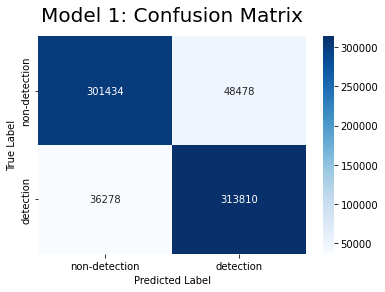

In [26]:
get_confusion_matrix(y_test, predictions, mat_title = 'Model 1: Confusion Matrix')